# 用線性迴歸驗證積體電路及繪圖顯卡的電晶體密度隨年份的增加趨勢

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

## 從[Wikipedia](https://en.wikipedia.org/wiki/Transistor_count)匯入資料 並找到對應的表格

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/Transistor_count')

In [3]:
print(len(df))
df[0].head()

15


,0,1,2,3,4,5
0,Processor,Transistor count,Date of introduction,Designer,Process,Area
1,Intel 4004,2300,1971,Intel,"10,000 nm",12 mm²
2,Intel 8008,3500,1972,Intel,"10,000 nm",14 mm²
3,MOS Technology 6502,"3,510[3]",1975,MOS Technology,"8,000 nm",21 mm²
4,Motorola 6800,4100,1974,Motorola,"6,000 nm",16 mm²


## 清理資料
### 1. 把想要的資料做成dataframe 加上column name 並把Area 改成 Area (mm²)
### 2. 把資料上移一列


In [4]:
transistor = df[0]
col_name = []
for i in transistor.loc[0,:].values:
    col_name.append(i)
col_name[5] = 'Area(mm²)'
transistor.columns = col_name
transistor = transistor.iloc[1:,:]

### 3. 檢查有沒有NaN的欄位 有的話就去掉(Transisior count及Area(mm²)這兩行都有) 
### 4. 其中有兩列 Transistor count 有 > 的符號(都是在2015年) 這兩列也一併去掉(因為無法計算相應的電晶體密度)

In [5]:
transistor.isnull().any()

Processor               False
Transistor count         True
Date of introduction    False
Designer                False
Process                 False
Area(mm²)                True
dtype: bool

In [6]:
transistor = transistor[transistor['Area(mm²)'].notna()]
transistor = transistor[transistor['Transistor count'].notna()]
for i in transistor['Transistor count']:
    if '>' in i:
        transistor = transistor.drop(transistor[transistor['Transistor count']==i].index, axis=0 )
transistor.index = range(1,len(transistor.index)+1)

看一下有沒有順利去掉有>符號的欄位

In [7]:
transistor[transistor['Date of introduction'] == '2015'].head()

,Processor,Transistor count,Date of introduction,Designer,Process,Area(mm²)
80,Quad-core + GPU GT2 Core i7 Skylake K,1750000000,2015,Intel,14 nm,122 mm²
82,Dual-core + GPU Iris Core i7 Broadwell-U,"1,900,000,000[26]",2015,Intel,14 nm,133 mm²
100,IBM z13,3990000000,2015,IBM,22 nm,678 mm²
116,IBM z13 Storage Controller,7100000000,2015,IBM,22 nm,678 mm²


### 5. wiki很貼心的幫大家附上citation 可是會造成資料處理的不便 所以把citation拿掉
### 6. 把 Area 裡面的 mm² 拿掉
### 7. 把所有數值裡的逗號拿掉

In [8]:
rewrite = []
for i in transistor['Transistor count']:
    if '[' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == '[':
                break
            temp += i[j]
            j += 1
        temp = temp.replace(',','')
        rewrite.append(temp)
    else:
        rewrite.append(i)
transistor['Transistor count'] = rewrite

rewrite = []
for i in transistor['Area(mm²)']:
    if 'mm' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == 'm':
                break
            temp += i[j]
            j += 1
#        temp = temp.replace(',','')
        rewrite.append(temp)
    else:
        rewrite.append(i)
transistor['Area(mm²)'] = rewrite


rewrite = []
for i in transistor['Date of introduction']:
    if '[' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == '[':
                break
            temp += i[j]
            j += 1
        rewrite.append(temp)
    else:
        rewrite.append(i)
transistor['Date of introduction'] = rewrite

### 8. 做一些有用的list 包括 Transistor_count, area,以及year 方便之後從裡面去產生training data跟testing data
### 9. 計算單位面積的電晶體數量(電晶體密度) 並添加到原本的dataframe裡

In [9]:
Transistor_count = np.zeros(len(transistor.index))
Area = np.zeros(len(transistor.index))
Year = np.zeros(len(transistor.index))
for i in range(0,len(transistor.index)):
    Transistor_count[i] = float(transistor['Transistor count'].values[i])
    Area[i] = float(transistor['Area(mm²)'].values[i])
    Year[i] = int(transistor['Date of introduction'].values[i])

count_per_area = Transistor_count/Area
transistor['Transistor count/Area (count/mm²)'] = count_per_area

## 最後dataFrame長這樣

In [10]:
transistor.head()

,Processor,Transistor count,Date of introduction,Designer,Process,Area(mm²),Transistor count/Area (count/mm²)
1,Intel 4004,2300,1971,Intel,"10,000 nm",12,191.666667
2,Intel 8008,3500,1972,Intel,"10,000 nm",14,250.000000
3,MOS Technology 6502,3510,1975,MOS Technology,"8,000 nm",21,167.142857
4,Motorola 6800,4100,1974,Motorola,"6,000 nm",16,256.250000
5,Intel 8080,4500,1974,Intel,"6,000 nm",20,225.000000


## 把list轉成float 之後就可以從裡面挑選testing data及training data

In [11]:
x = Year.reshape(len(Year),1)
y = np.log10(count_per_area)
z = np.log10(Transistor_count)

## 產生 testing data 跟 training data
### 1. 可以用上課教的方產生testing data 跟 training data

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state= 5566)
#print(len(x_test),len(x_train))

### 2. 不過因為想要在data point旁邊加上相應積體電路的名稱 所以只好自己產生QQ

In [12]:
TF = []
np.random.seed(5566)
for i in range (0,len(transistor.index)):
    if np.random.rand()>=0.8:
        TF.append(True)
    else:
        TF.append(False)
x_test = x[TF]
y_test = y[TF]
z_test = z[TF]
label_test = transistor['Processor'][TF].values

for i in range(0,len(TF)):
    TF[i] = not TF[i]
x_train = x[TF]
y_train = y[TF]
z_train = z[TF]
label_train = transistor['Processor'][TF].values

del TF
print(len(x_test),len(x_train))

29 97


## 畫張 training data 的圖: 電晶體密度及電晶體數量隨年份變化的趨勢 

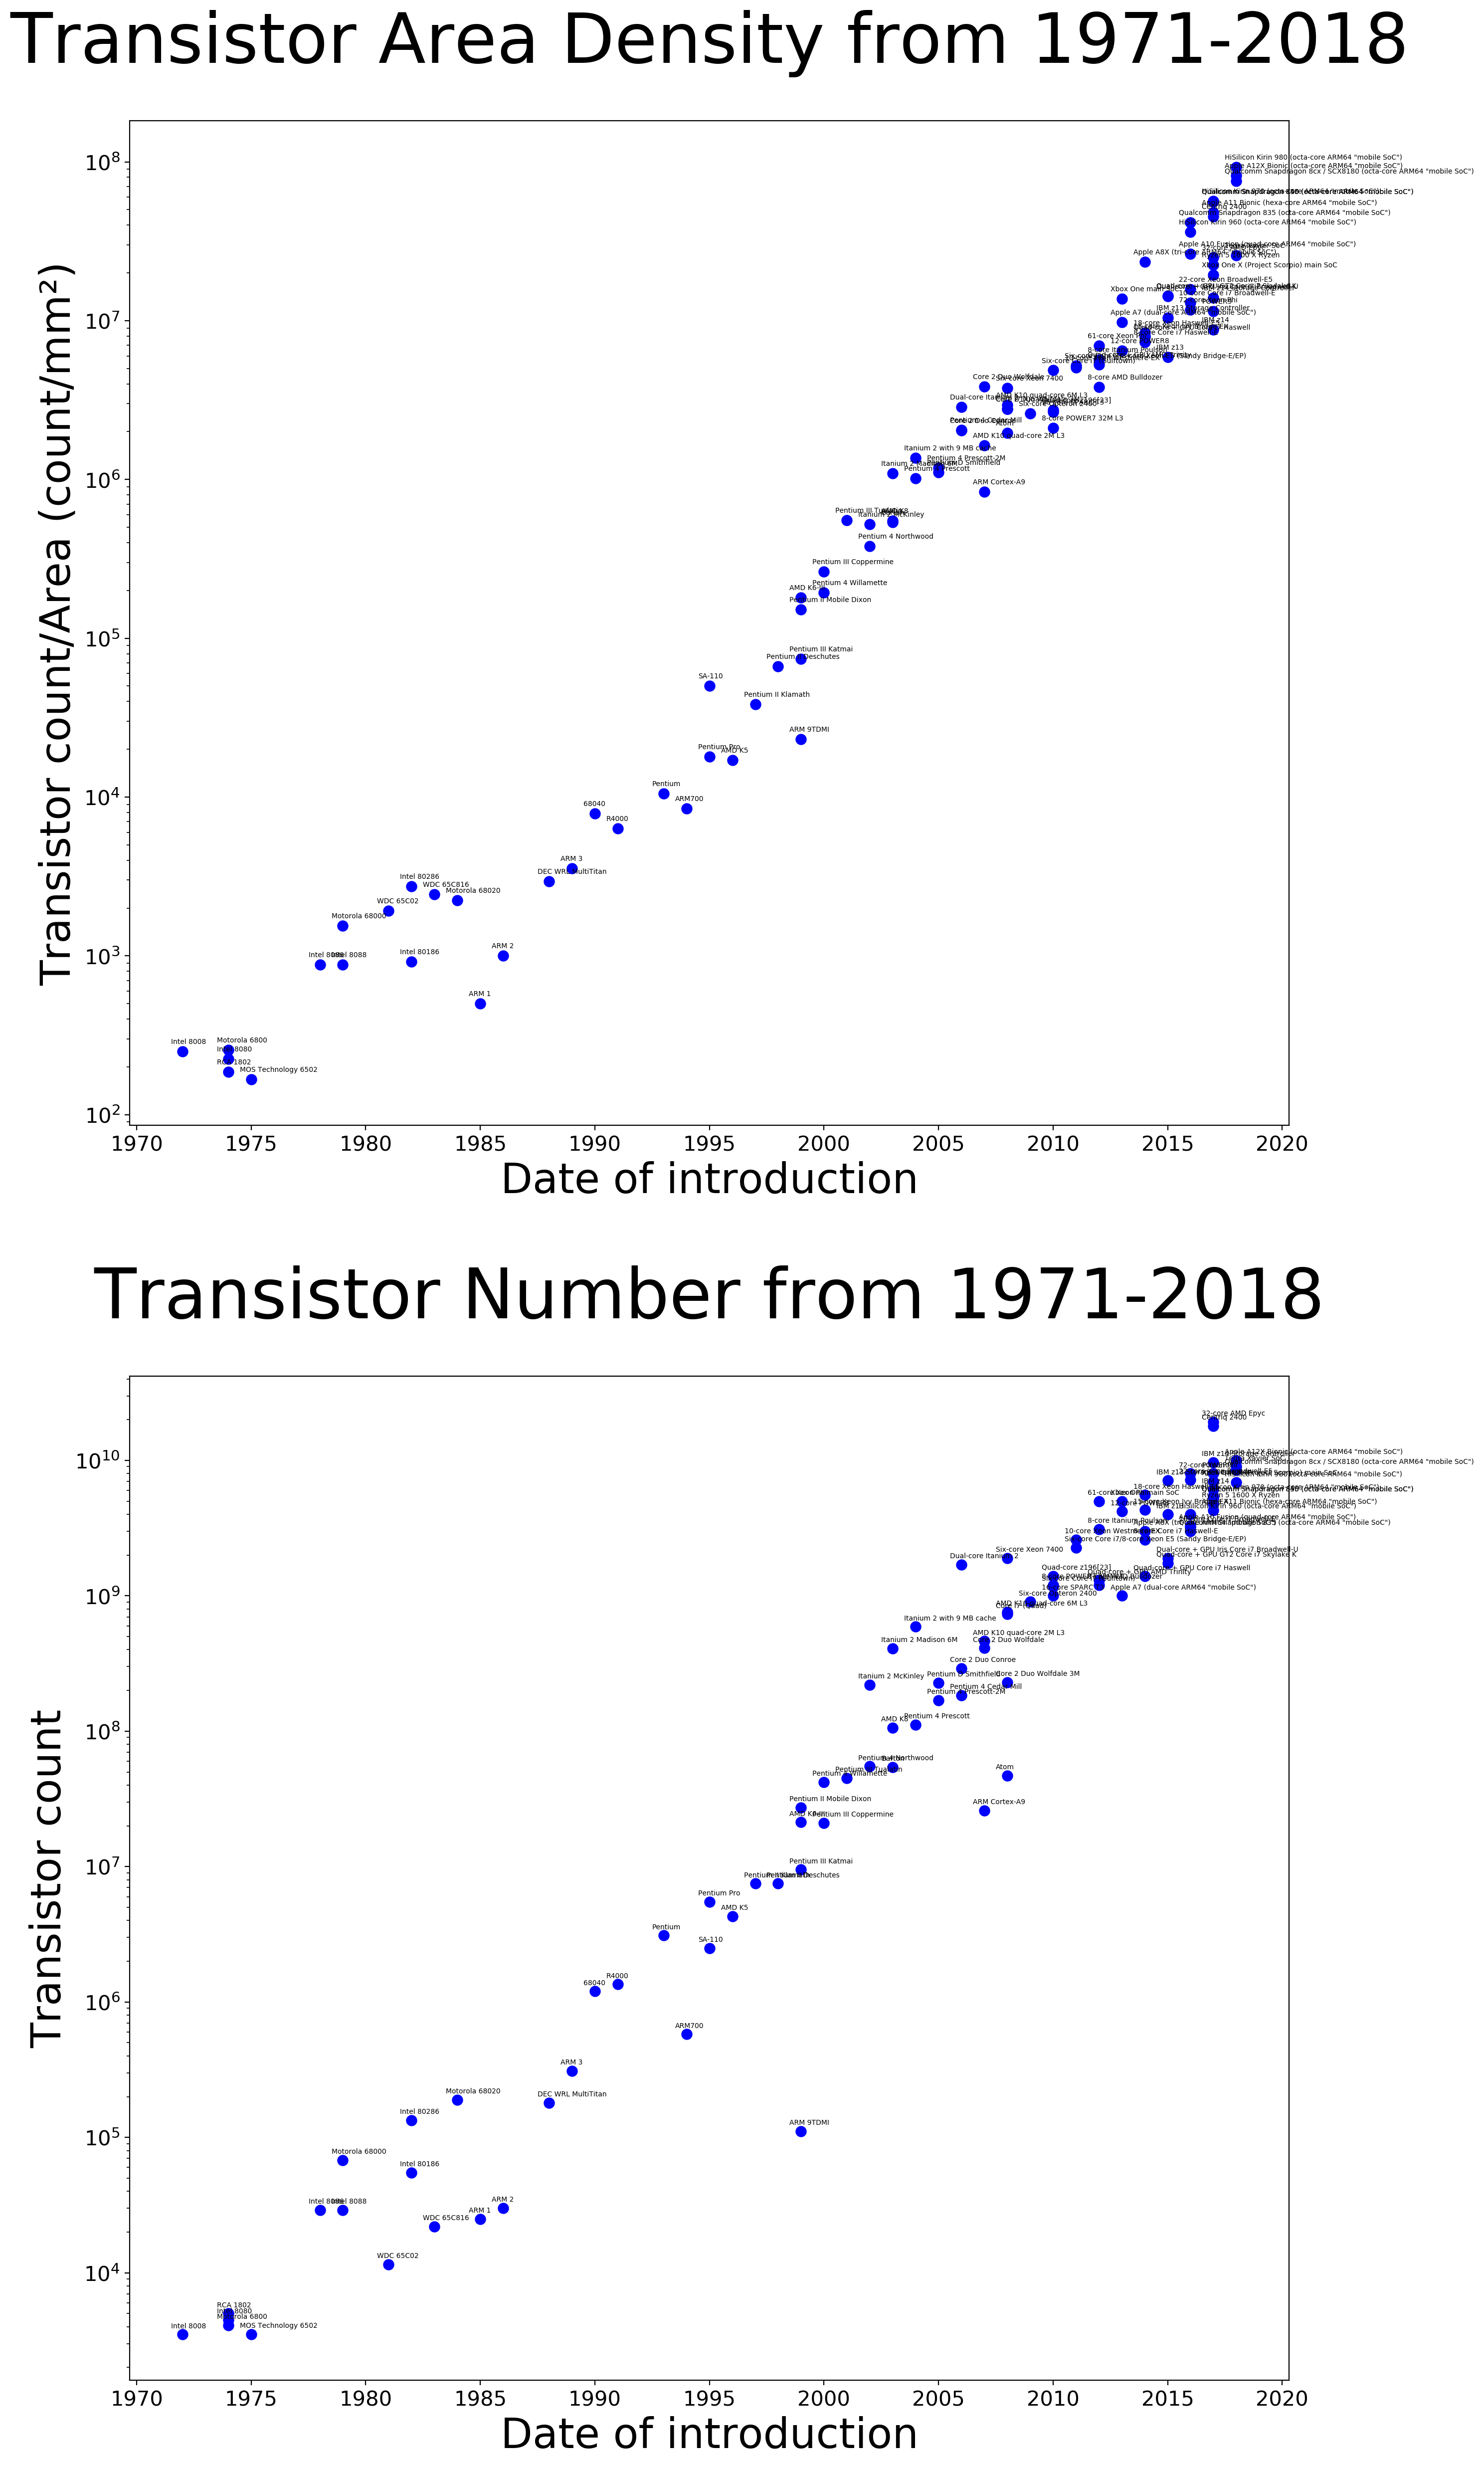

In [13]:
fig = plt.figure(figsize=(15,30), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0 = plt.yscale('log')
ax0 = plt.scatter(x_train,10**y_train,c='b',s=50)
ax0 = plt.xlabel(transistor.columns[2],fontsize=30)
ax0 = plt.ylabel(transistor.columns[-1],fontsize=30)
ax0 = plt.xticks(range(1970,2021,5),fontsize=15)
ax0 = plt.yticks(fontsize=15)
ax0 = plt.title('Transistor Area Density from 1971-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_train)):
    ax0 = plt.text(x_train[i]-0.5,10**(y_train[i]+0.05),label_train[i],fontsize=5.0)

plt.subplots_adjust(wspace=0, hspace=0.25) #調整兩張圖之間的距離 

ax1 = plt.subplot(2,1,2)
ax1 = plt.yscale('log')
ax1 = plt.scatter(x_train,10**z_train,c='b',s=50)
ax1 = plt.xlabel(transistor.columns[2],fontsize=30)
ax1 = plt.ylabel(transistor.columns[1],fontsize=30)
ax1 = plt.xticks(range(1970,2021,5),fontsize=15)
ax1 = plt.yticks(fontsize=15)
ax1 = plt.title('Transistor Number from 1971-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_train)):
    ax1 = plt.text(x_train[i]-0.5,10**(z_train[i]+0.05),label_train[i],fontsize=5.0)

plt.show()

## 開始訓練

In [14]:
regr1 = LinearRegression() # for transistor area density
regr1.fit(x_train,y_train)
y_pre = regr1.predict(x_test)
regr2 = LinearRegression() # for transistor number
regr2.fit(x_train,z_train)
z_pre = regr2.predict(x_test)

## 把訓練得到的參數拿去做預測 並對正確結果畫圖做比較

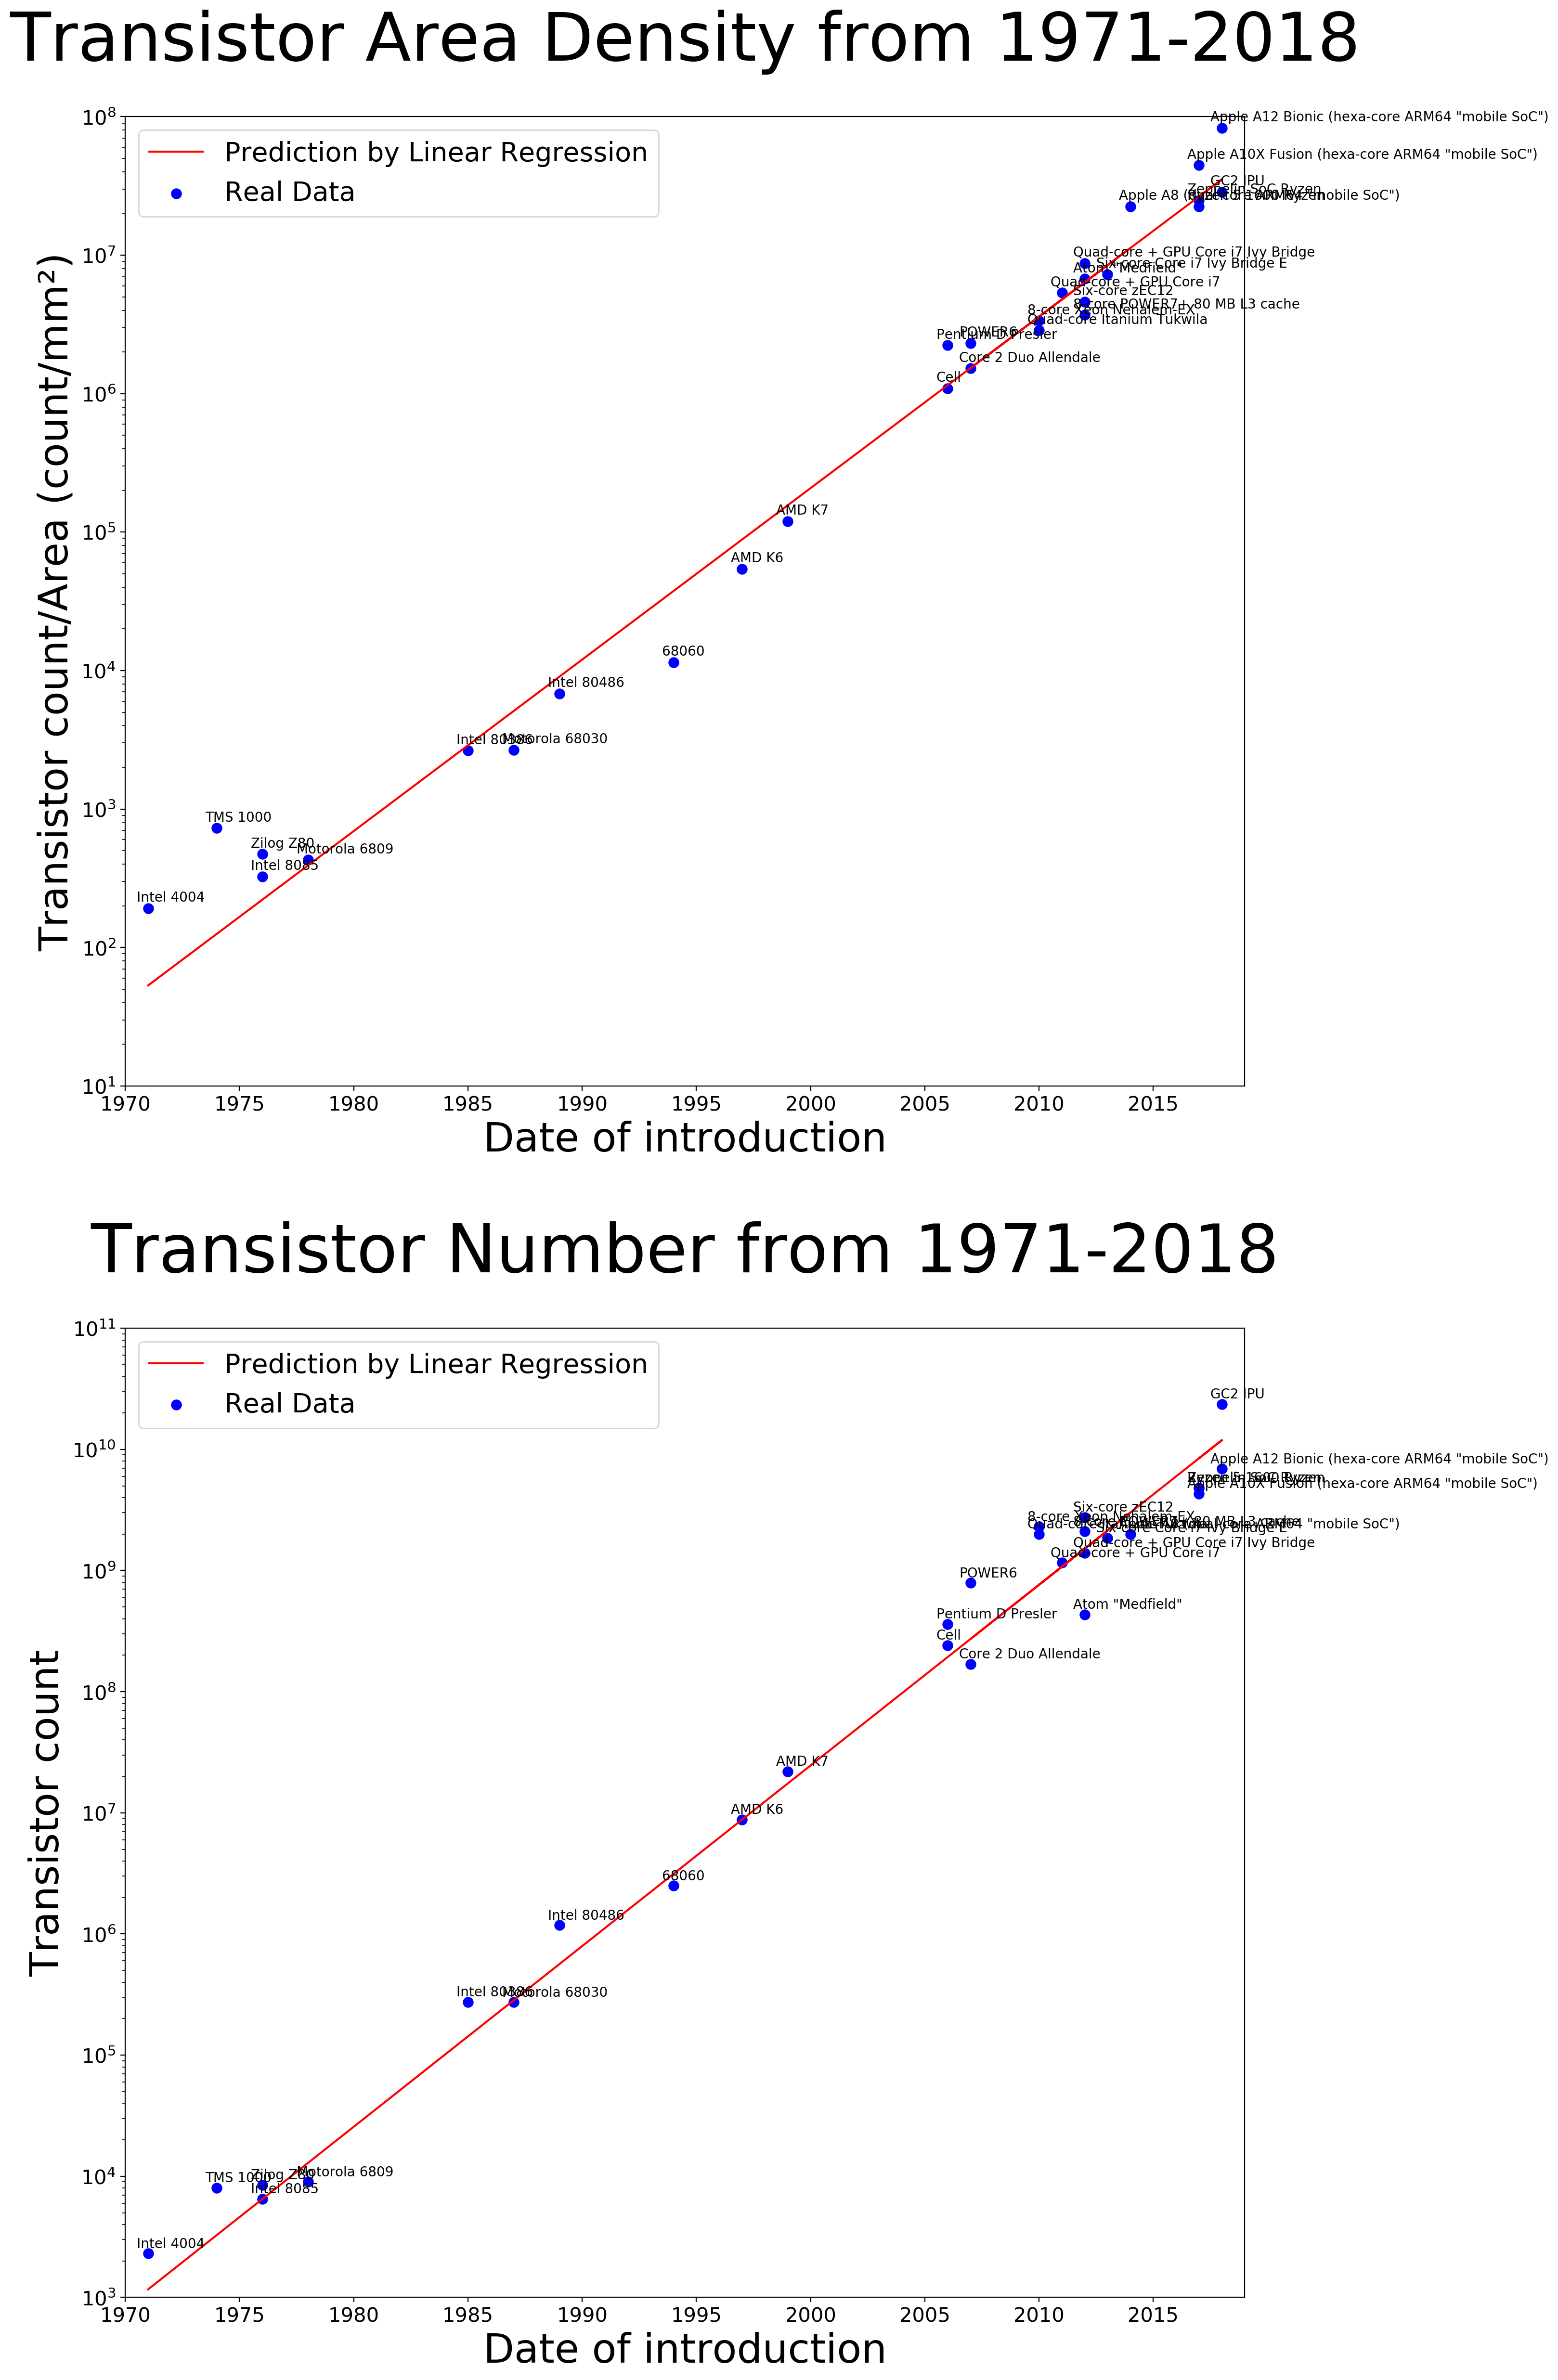

In [15]:
fig = plt.figure(figsize=(15,30), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0 = plt.yscale('log')
ax0 = plt.scatter(x_test,10**y_test,c='b',s=50, label='Real Data')
ax0 = plt.plot(x_test, 10**y_pre, 'r',label='Prediction by Linear Regression')
ax0 = plt.xlabel(transistor.columns[2],fontsize=30)
ax0 = plt.ylabel(transistor.columns[-1],fontsize=30)
ax0 = plt.xticks(range(1970,2021,5),fontsize=15)
ax0 = plt.yticks(fontsize=15)
ax0 = plt.xlim(1970,2019)
ax0 = plt.ylim(1e1,1e8)
ax0 = plt.legend(loc='upper left', prop={'size': 20})
ax0 = plt.title('Transistor Area Density from 1971-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_test)):
    ax0 = plt.text(x_test[i]-0.5,10**(y_test[i]+0.05),label_test[i],fontsize=10.0)

plt.subplots_adjust(wspace=0, hspace=0.25) #調整兩張圖之間的距離 

ax1 = plt.subplot(2,1,2)
ax1 = plt.yscale('log')
ax1 = plt.scatter(x_test,10**z_test,c='b',s=50, label='Real Data')
ax1 = plt.plot(x_test, 10**z_pre, 'r',label='Prediction by Linear Regression')
ax1 = plt.xlabel(transistor.columns[2],fontsize=30)
ax1 = plt.ylabel(transistor.columns[1],fontsize=30)
ax1 = plt.xticks(range(1970,2021,5),fontsize=15)
ax1 = plt.yticks(fontsize=15)
ax1 = plt.xlim(1970,2019)
ax1 = plt.ylim(1e3,1e11)
ax1 = plt.legend(loc='upper left', prop={'size': 20})
ax1 = plt.title('Transistor Number from 1971-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_test)):
    ax1 = plt.text(x_test[i]-0.5,10**(z_test[i]+0.05),label_test[i],fontsize=10.0)

plt.show()

## 看看預測結果的準確率

In [16]:
print(f'電晶體密度的準確率是: {100*regr1.score(x_test,y_test)}')
print(f'電晶體數目的準確率是: {100*regr2.score(x_test,z_test)}')

電晶體密度的準確率是: 97.93003438113955
電晶體數目的準確率是: 98.56088261209878


## 順便用學習的結果預測未來年份的電晶體密度 (太遙遠的未來預測結果應該不可信啦XD)

In [17]:
print('來預測電晶體的未來吧\n')
x_future = ''
while x_future!='end':
    x_future = input('請輸入您想預測的西元年份(輸入end結束)')
    if x_future.isdigit():
        if float(x_future) < 2019:
            print('請您看向未來')
        else:
            temp = np.array([float(x_future)])
            temp = temp.reshape(len(temp),1)
            count_future = 10**regr1.predict(temp)
            print('西元'+x_future + f'年電晶體密度預測是: {count_future[0]:.4e} (個/mm²)')
            count_future = 10**regr2.predict(temp)
            print('西元'+x_future + f'年電晶體數目預測是: {count_future[0]:.4e} (個)\n')
            
    elif x_future != 'end':
        print('您不知道西元年份是什麼嗎 OWO?')


來預測電晶體的未來吧

請輸入您想預測的西元年份(輸入end結束)2020
西元2020年電晶體密度預測是: 6.2315e+07 (個/mm²)
西元2020年電晶體數目預測是: 2.3625e+10 (個)

請輸入您想預測的西元年份(輸入end結束)2022
西元2022年電晶體密度預測是: 1.1023e+08 (個/mm²)
西元2022年電晶體數目預測是: 4.6949e+10 (個)

請輸入您想預測的西元年份(輸入end結束)end


### [Moore's Law](https://en.wikipedia.org/wiki/Moore%27s_law) 預言了積體電路的電晶體數目每兩年會增加兩倍 感覺跟現有的資料符合得好到有點可怕 只是接下來可能會面臨到線寬窄度的極限及量子穿隧的效應 希望各電晶體的大廠能繼續努力維持Moore's Law 囉 > <

## 再來試試預測繪圖顯卡的電晶體密度(做法跟上面很類似 就不贅述囉~)

In [18]:
gpu_transistor = df[3]
col_name = []
for i in gpu_transistor.loc[0,:].values:
    col_name.append(i)
col_name[5] = 'Area(mm²)'
gpu_transistor.columns = col_name
gpu_transistor = gpu_transistor.iloc[1:,:]

In [19]:
gpu_transistor = gpu_transistor[gpu_transistor['Transistor count'].notna()]
gpu_transistor = gpu_transistor[gpu_transistor['Area(mm²)'].notna()]
gpu_transistor.index = range(1,len(gpu_transistor.index)+1)

In [20]:
rewrite = []
for i in gpu_transistor['Transistor count']:
    if '[' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == '[':
                break
            temp += i[j]
            j += 1
        temp = temp.replace(',','')
        rewrite.append(temp)
    else:
        rewrite.append(i)
gpu_transistor['Transistor count'] = rewrite

rewrite = []
for i in gpu_transistor['Area(mm²)']:
    if 'mm' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == 'm':
                break
            temp += i[j]
            j += 1
        rewrite.append(temp)
    else:
        rewrite.append(i)
gpu_transistor['Area(mm²)'] = rewrite

rewrite = []
for i in gpu_transistor['Date of introduction']:
    if '[' in i :
        temp = ''
        j = 0
        while temp in i:
            if i[j] == '[':
                break
            temp += i[j]
            j += 1
        rewrite.append(temp)
    else:
        if 'Mar' in i:
            i = i.replace(' Mar','.25')
        elif 'Nov' in i:
            i = i.replace(' Nov','.917')
        rewrite.append(i)
gpu_transistor['Date of introduction'] = rewrite

In [21]:
Transistor_count = np.zeros(len(gpu_transistor.index))
Area = np.zeros(len(gpu_transistor.index))
Year = np.zeros(len(gpu_transistor.index))
for i in range(0,len(gpu_transistor.index)):
    Transistor_count[i] = float(gpu_transistor['Transistor count'].values[i])
    Area[i] = float(gpu_transistor['Area(mm²)'].values[i])
    Year[i] = float(gpu_transistor['Date of introduction'].values[i])

count_per_area = Transistor_count/Area

In [22]:
gpu_transistor['Transistor count/Area (count/mm²)'] = count_per_area

In [23]:
gpu_transistor.head()

,Processor,Transistor count,Date of introduction,Manufacturer,Process,Area(mm²),Transistor count/Area (count/mm²)
1,NV3,3500000,1997,NVIDIA,350 nm,90,38888.888889
2,Rage 128,8000000,1999,AMD,250 nm,70,114285.714286
3,NV10,23000000,1999,Nvidia,220 nm,111,207207.207207
4,NV11,20000000,2000,Nvidia,180 nm,65,307692.307692
5,NV15,25000000,2000,Nvidia,180 nm,81,308641.975309


In [24]:
x = Year.reshape(len(Year),1)
y = np.log10(count_per_area)
z = np.log10(Transistor_count)

In [25]:
TF = []
np.random.seed(5566948)
for i in range (0,len(gpu_transistor.index)):
    if np.random.rand()>=0.8:
        TF.append(True)
    else:
        TF.append(False)
x_test = x[TF]
y_test = y[TF]
z_test = z[TF]
label_test = gpu_transistor['Processor'][TF].values

for i in range(0,len(TF)):
    TF[i] = not TF[i]
x_train = x[TF]
y_train = y[TF]
z_train = z[TF]
label_train = gpu_transistor['Processor'][TF].values

del TF
print(len(label_test),len(x_train))

17 62


## 繪圖顯卡的電晶體密度及電晶體數量隨年份變化的趨勢

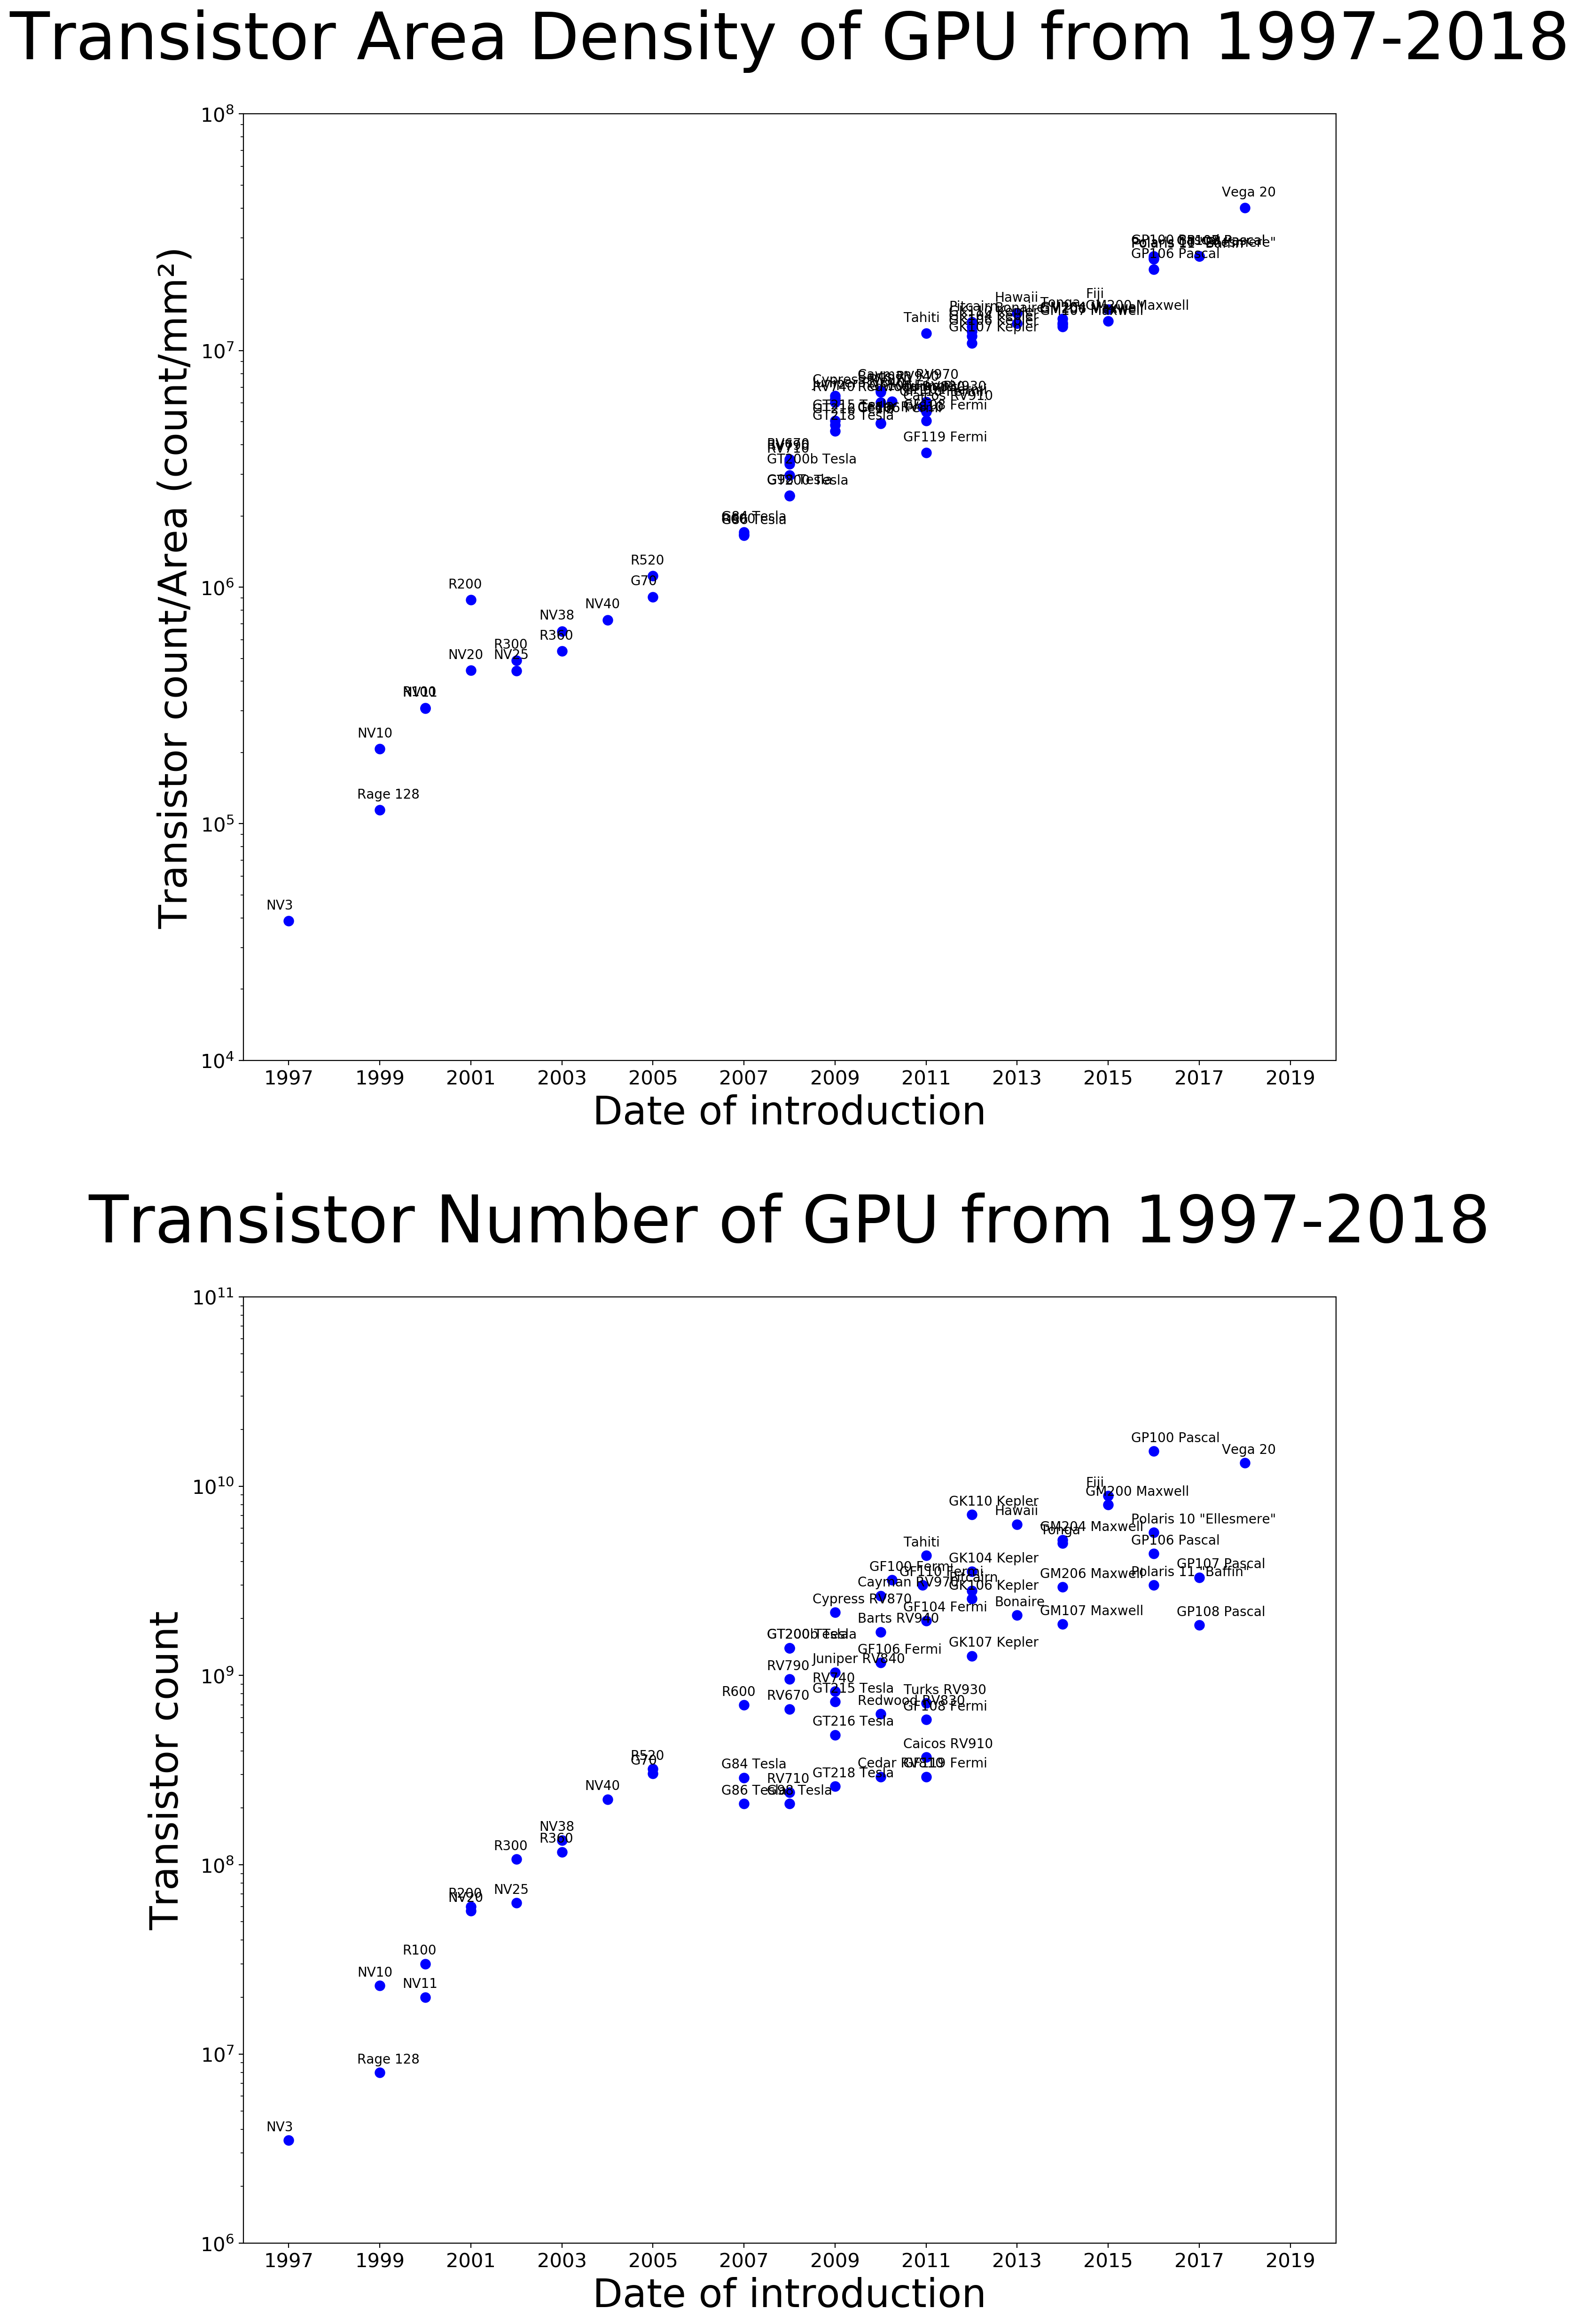

In [26]:
fig = plt.figure(figsize=(15,30), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0 = plt.yscale('log')
ax0 = plt.scatter(x_train,10**y_train,c='b',s=50)
ax0 = plt.xlabel(gpu_transistor.columns[2],fontsize=30)
ax0 = plt.ylabel(gpu_transistor.columns[-1],fontsize=30)
ax0 = plt.xticks(range(1997,2021,2),fontsize=15)
ax0 = plt.yticks(10**np.arange(4,9,1.0),fontsize=15)
ax0 = plt.xlim(1996,2020)
ax0 = plt.ylim(1e4,1e8)
ax0 = plt.title('Transistor Area Density of GPU from 1997-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_train)):
    ax0 = plt.text(x_train[i]-0.5,10**(y_train[i]+0.05),label_train[i],fontsize=10.0)

plt.subplots_adjust(wspace=0, hspace=0.25)   

ax1 = plt.subplot(2,1,2)
ax1 = plt.yscale('log')
ax1 = plt.scatter(x_train,10**z_train,c='b',s=50)
ax1 = plt.xlabel(gpu_transistor.columns[2],fontsize=30)
ax1 = plt.ylabel(gpu_transistor.columns[1],fontsize=30)
ax1 = plt.xlim(1996,2020)
ax1 = plt.xticks(range(1997,2021,2),fontsize=15)
ax1 = plt.yticks(10**np.arange(6,12,1.0),fontsize=15)
ax1 = plt.ylim(1e6,1e11)
ax1 = plt.title('Transistor Number of GPU from 1997-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_train)):
    ax1 = plt.text(x_train[i]-0.5,10**(z_train[i]+0.05),label_train[i],fontsize=10.0)
plt.show()

In [27]:
regr3 = LinearRegression() # for GPU transistor area density
regr3.fit(x_train,y_train)
y_pre = regr3.predict(x_test)
regr4 = LinearRegression() # for GPU transistor number
regr4.fit(x_train,z_train)
z_pre = regr4.predict(x_test)

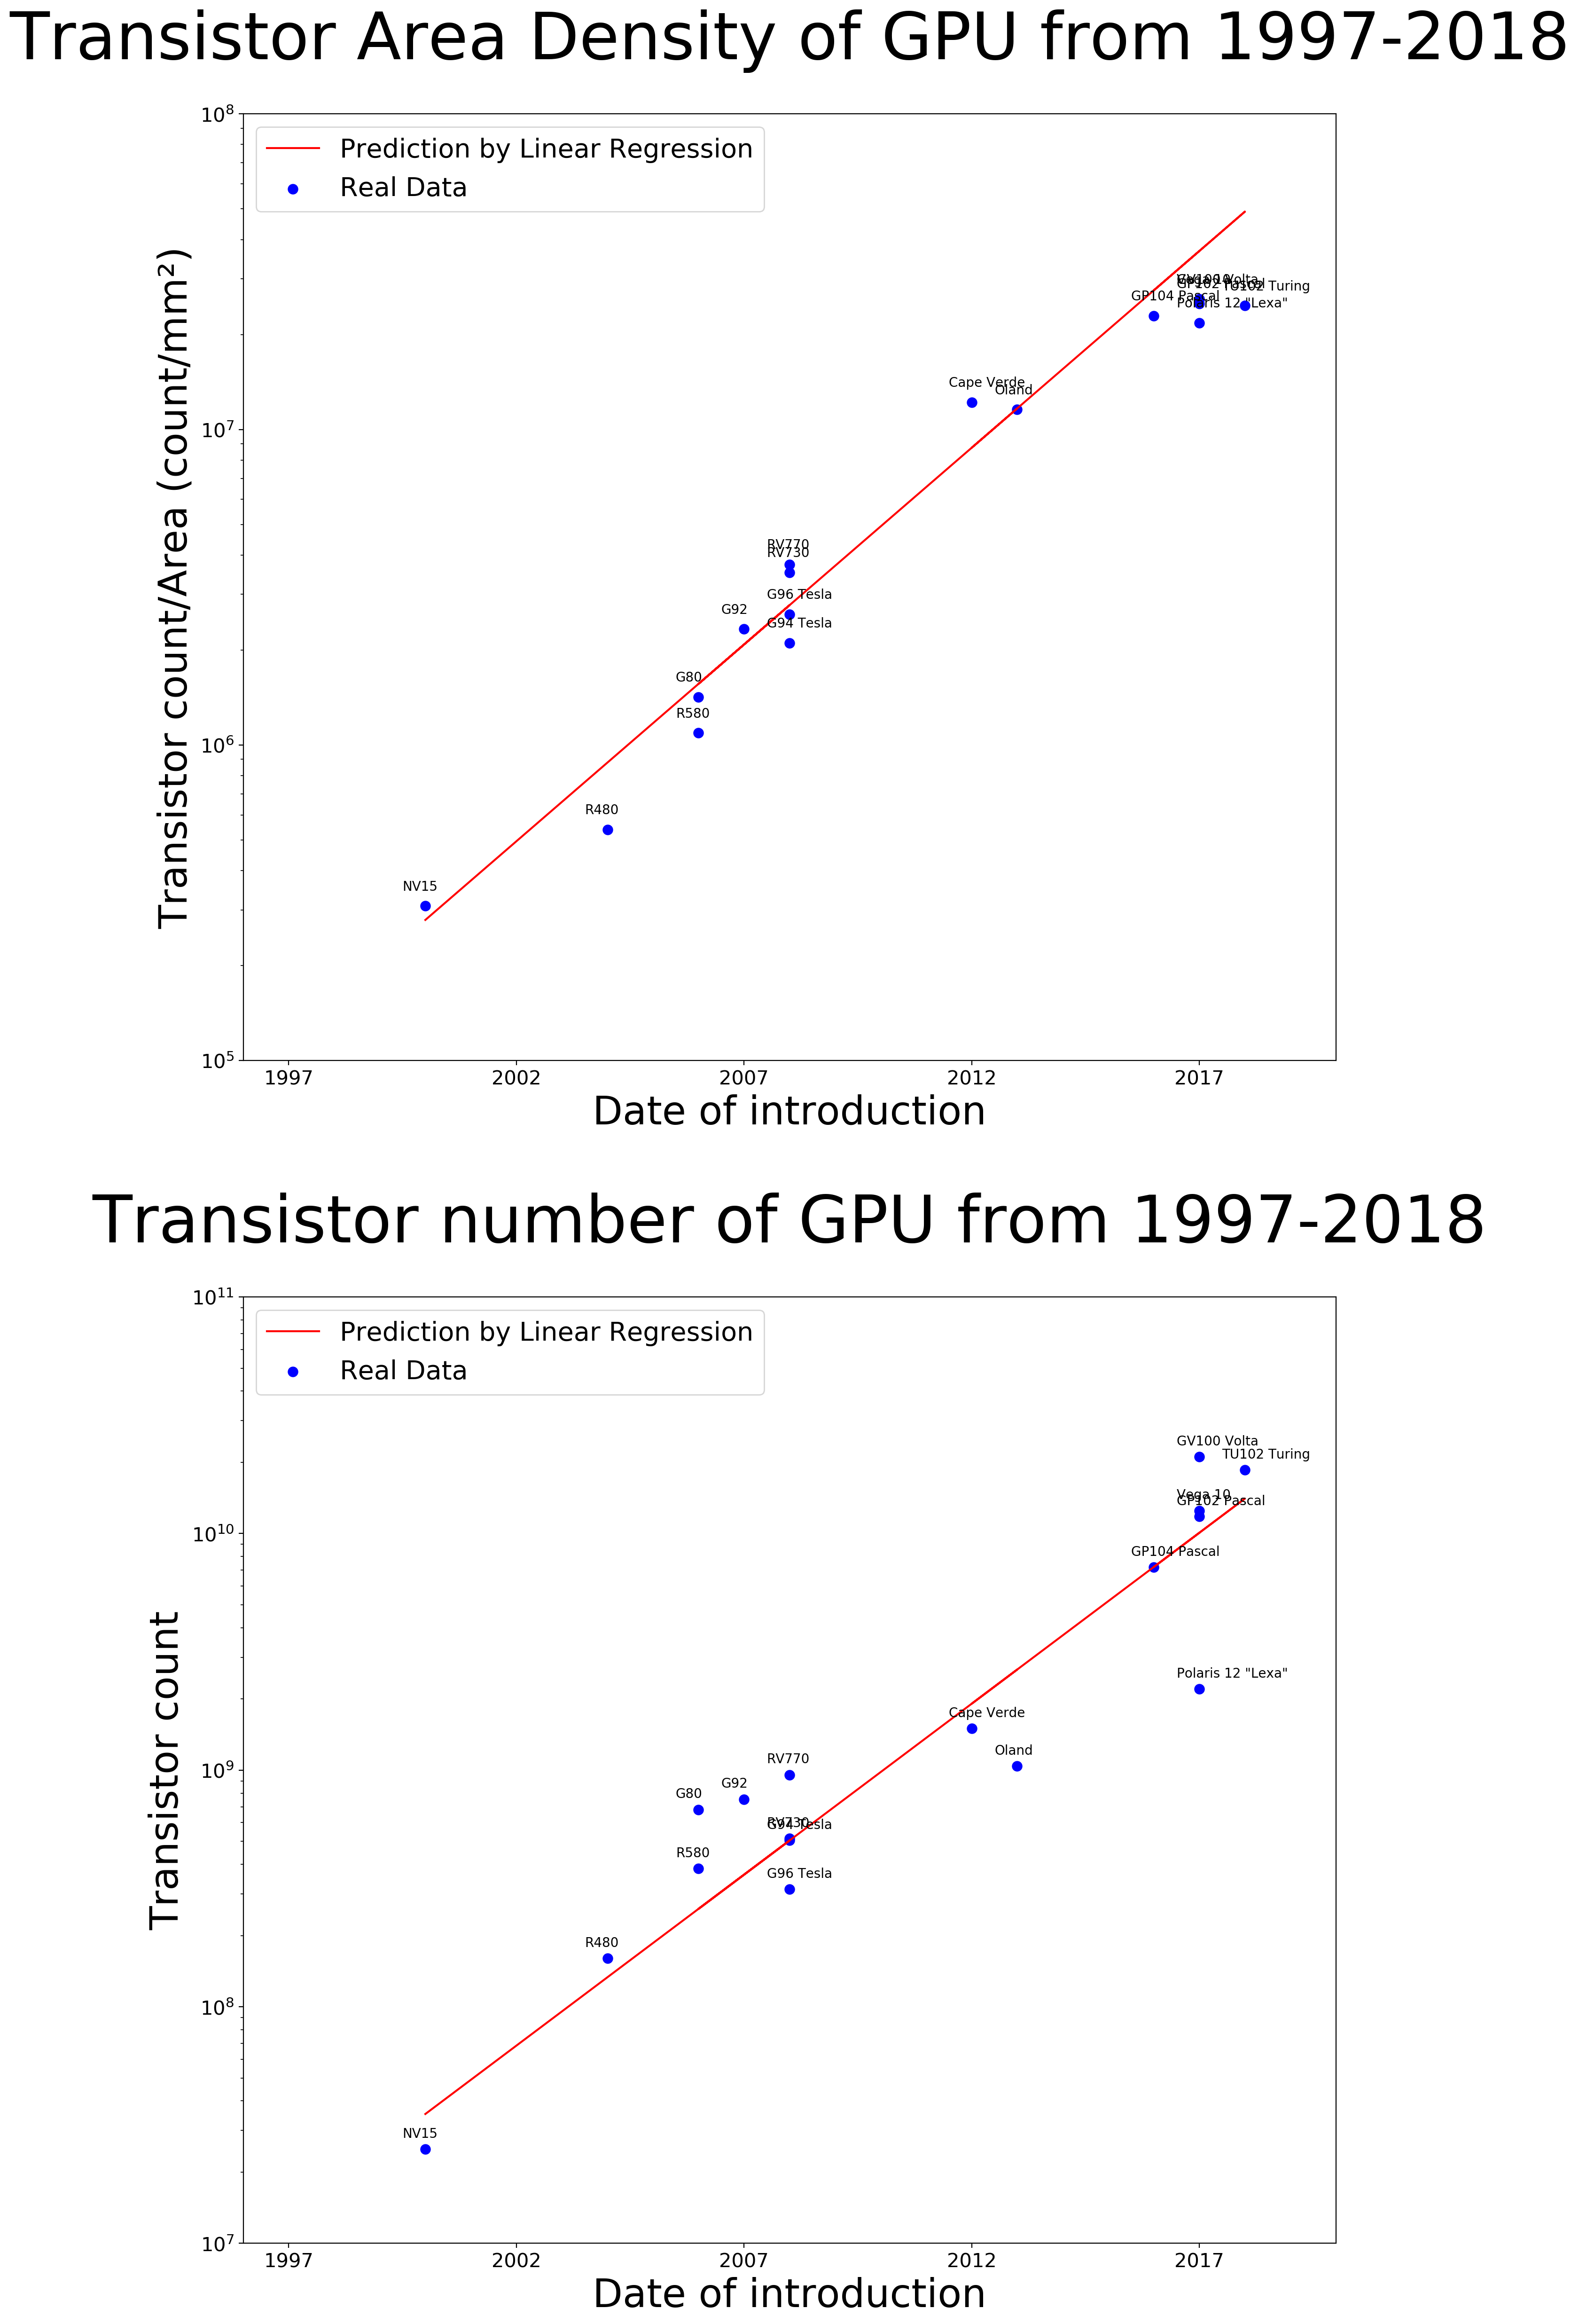

In [28]:
plt.figure(figsize=(15,30), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0 = plt.yscale('log')
ax0 = plt.scatter(x_test,10**y_test,c='b',s=50, label='Real Data')
ax0 = plt.plot(x_test, 10**y_pre, 'r',label='Prediction by Linear Regression')
ax0 = plt.xlabel(gpu_transistor.columns[2],fontsize=30)
ax0 = plt.ylabel(gpu_transistor.columns[-1],fontsize=30)
ax0 = plt.xticks(range(1997,2021,5),fontsize=15)
ax0 = plt.yticks(fontsize=15)
ax0 = plt.xlim(1996,2020)
ax0 = plt.ylim(1e5,1e8)
ax0 = plt.legend(loc='upper left', prop={'size': 20})
ax0 = plt.title('Transistor Area Density of GPU from 1997-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_test)):
    ax0 = plt.text(x_test[i]-0.5,10**(y_test[i]+0.05),label_test[i],fontsize=10.0)

plt.subplots_adjust(wspace=0, hspace=0.25)
    
ax1 = plt.subplot(2,1,2)
ax1 = plt.yscale('log')
ax1 = plt.scatter(x_test,10**z_test,c='b',s=50, label='Real Data')
ax1 = plt.plot(x_test, 10**z_pre, 'r',label='Prediction by Linear Regression')
ax1 = plt.xlabel(gpu_transistor.columns[2],fontsize=30)
ax1 = plt.ylabel(gpu_transistor.columns[1],fontsize=30)
ax1 = plt.xticks(range(1997,2021,5),fontsize=15)
ax1 = plt.yticks(fontsize=15)
ax0 = plt.xlim(1996,2020)
ax0 = plt.ylim(1e7,1e11)
ax1 = plt.legend(loc='upper left', prop={'size': 20})
ax1 = plt.title('Transistor number of GPU from 1997-2018', fontsize = 50, y=1.05)
for i in range(0,len(x_test)):
    ax1 = plt.text(x_test[i]-0.5,10**(z_test[i]+0.05),label_test[i],fontsize=10.0)
plt.show()

In [29]:
print(f'繪圖顯卡電晶體密度的準確率是: {100*regr3.score(x_test,y_test)}')
print(f'繪圖顯卡電晶體數目的準確率是: {100*regr4.score(x_test,z_test)}')

繪圖顯卡電晶體密度的準確率是: 94.55605996812504
繪圖顯卡電晶體數目的準確率是: 88.25322835443795


In [30]:
print('來預測繪圖顯卡的未來吧\n')
x_future = ''
while x_future!='end':
    x_future = input('請輸入您想預測的西元年份(輸入end結束)')
    if x_future.isdigit():
        if float(x_future) < 2019:
            print('請您看向未來')
        else:
            temp = np.array([float(x_future)])
            temp = temp.reshape(len(temp),1)
            count_future = 10**regr3.predict(temp)
            print('西元'+x_future + f'年繪圖顯卡電晶體密度預測是: {count_future[0]:.4e} (個/mm²)')
            count_future = 10**regr4.predict(temp)
            print('西元'+x_future + f'年繪圖顯卡電晶體數目預測是: {count_future[0]:.4e} (個)\n')
            
    elif x_future != 'end':
        print('您不知道西元年份是什麼嗎 OWO?')

來預測繪圖顯卡的未來吧

請輸入您想預測的西元年份(輸入end結束)2020
西元2020年繪圖顯卡電晶體密度預測是: 8.7024e+07 (個/mm²)
西元2020年繪圖顯卡電晶體數目預測是: 2.7329e+10 (個)

請輸入您想預測的西元年份(輸入end結束)2022
西元2022年繪圖顯卡電晶體密度預測是: 1.5456e+08 (個/mm²)
西元2022年繪圖顯卡電晶體數目預測是: 5.3164e+10 (個)

請輸入您想預測的西元年份(輸入end結束)end


### 繪圖顯卡上的電晶體數目似乎沒有那麼符合Moore's Law 數目成長的趨勢用線性迴歸也沒符合得像積體電路那麼好 不過電晶體密度倒是符合得不錯

## 心得: 感覺線性迴歸這個方法好像不需要x對y是一對一或多對一的映射呢 像在晶體電路的例子 同一個年份不同廠商設計出來的積體電路可能有不同的電晶體數目或密度(所以是一對多的映射) 可是線性迴歸還是可以學出很好的結果 是因為就算有很多個y還是能夠計算loss function(管他x一不一樣) 然後把loss function最小化嗎?(只是在這樣的情況下 就算其他一對一映射的(x,y)都在預測的直線上 loss function 雖然最小化了 還是不為0是嗎)
